In [3]:
import os, pickle, time
import numpy
import cupy
import matplotlib.pylab as plt
import pandas as pd
from dataset.mnist import load_mnist

%matplotlib inline

# 一度に処理する画像ファイルの数
BATCH_SIZE = [1, 10, 100, 500, 1000, 5000, 10000]

#-------------------------------------------------------------------------------
def get_data():
    (xtrain, ttrain), (xtest, ttest) = load_mnist(
      normalize = True, flatten = True, one_hot_label = False)
    return xtest, ttest

#-------------------------------------------------------------------------------
def init_network(xp):
    # 学習済みの重みとバイアスの読み込み
    with open('sample_weight.pkl', 'rb') as f:
        network = pickle.load(f)
    
    if xp == cupy:
        W1, W2, W3 = network['W1'], network['W2'], network['W3']
        b1, b2, b3 = network['b1'], network['b2'], network['b3']
        # 重みとバイアスのデータをGPU側のメモリ (デバイスメモリ) へコピーする
        network['W1'] = cupy.asarray(W1, dtype = cupy.float32)
        network['W2'] = cupy.asarray(W2, dtype = cupy.float32)
        network['W3'] = cupy.asarray(W3, dtype = cupy.float32)
        network['b1'] = cupy.asarray(b1, dtype = cupy.float32)
        network['b2'] = cupy.asarray(b2, dtype = cupy.float32)
        network['b3'] = cupy.asarray(b3, dtype = cupy.float32)
        
    return network
  
#-------------------------------------------------------------------------------
def sigmoid(xp, x):
    return 1.0 / (1.0 + xp.exp(-x))

#-------------------------------------------------------------------------------
def softmax(xp, x):
    c = xp.max(x)
    exp_val = xp.exp(x - c) # avoid overflow
    sum_exp_val = xp.sum(exp_val)
    return exp_val / sum_exp_val

#-------------------------------------------------------------------------------
def predict(xp, network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    # layer-1
    a1 = xp.dot(x, W1) + b1
    z1 = sigmoid(xp, a1)
    # layer-2
    a2 = xp.dot(z1, W2) + b2
    z2 = sigmoid(xp, a2)
    # layer-3
    a3 = xp.dot(z2, W3) + b3
    y = softmax(xp, a3)
    return y

#-------------------------------------------------------------------------------
def process(xp, x, t, network, bsize):
  
    start = time.time() # 処理時間の測定開始
    
    accuracy_cnt = 0
    for i in range(0, len(x), bsize):
        
        xb = x[i : i + bsize]
            
        # 入力画像の推論
        # -> 出力データは０から９までの各数字の一致度（確率）
        yb = predict(xp, network, xb)
            
        # 一致度が最も高い数字を取り出す
        p = xp.argmax(yb, axis = 1)
            
        # 正解ラベルと比較して、正解した回数をカウントする
        accuracy_cnt += xp.sum(p == t[i : i + bsize])
        
    stop = time.time() # 処理時間の測定終了
    
    proc_time = stop - start
        
    if xp == cupy:
        # cupyのオブジェクトのままなので、numpyオブジェクトに変換
        accuracy_cnt = accuracy_cnt.get()
    
    return proc_time, accuracy_cnt
  
#-------------------------------------------------------------------------------
def benchmark(xp, x, t):
    
    # Arguments
    # xp: ライブラリ (numpy or cupy)
    # x:  入力画像データ
    # t:  正解ラベル
    
    # ニューラルネットワークの設定
    network = init_network(xp)
    
    # cupyは、初回はCUDAコードの自動生成とコンパイル作業が入ってしまう。
    # 2回目以降の処理は、コンパイル結果がキャッシュされているので高速になる。
    # そのため、cupy については同じ処理を2回実行し、2回目の処理時間を取得する。
    num_trial = 2
    #if xp == cupy:
    #    num_trial = 2
    
    accuracy = []
    proc_time = []    
    for bsize in BATCH_SIZE:
        
        for i in range(num_trial):
        
            ptime, accuracy_cnt = process(xp, x, t, network, bsize)
            
            if i == num_trial - 1:    
                proc_time.append(ptime)
                accuracy.append(accuracy_cnt / len(x))
        
    return accuracy, proc_time

## Numpyを使って推論

In [4]:
# MNISTのデータの読み込み 
# (x: 入力画像データ, t: 正解ラベル)
x, t = get_data()

# CPUで処理を実行
accuracy, proc_time = benchmark(numpy, x, t)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


## CuPyを使って推論

In [5]:
cupy.cuda.set_allocator(cupy.cuda.MemoryPool().malloc)

# MNISTのデータの読み込み
# x: 入力画像データ, t: 正解ラベル
x, t = get_data()

# 入力データ、正解ラベルをデバイスメモリへコピー
x = cupy.asarray(x, dtype = cupy.float32)
t = cupy.asarray(t, dtype = cupy.float32)

# GPUで処理を実行
g_accuracy, g_proc_time = benchmark(cupy, x, t)

/home/shogo/.pyenv/versions/anaconda3-2023.09-0/lib/python3.11/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()


## パフォーマンスの比較 (CPU vs GPU)

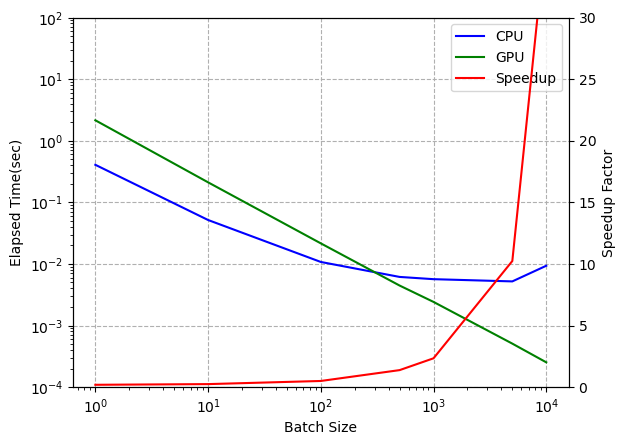

,Batch Size,Accuracy(CPU),Accuracy(GPU),Elapsed Time(CPU) (sec),Elapsed Time(GPU) (sec),Speedup Factor(CPU/GPU)
0,1,0.9352,0.9352,0.406477,2.147698,0.189262
1,10,0.9352,0.9352,0.051651,0.211192,0.244567
2,100,0.9352,0.9352,0.010760,0.021568,0.498872
3,500,0.9352,0.9352,0.006150,0.004457,1.380035
4,1000,0.9352,0.9352,0.005655,0.002416,2.340109
5,5000,0.9352,0.9352,0.005203,0.000508,10.236398
6,10000,0.9352,0.9352,0.009339,0.000253,36.951887


In [6]:
speedup = []
for i in range(len(BATCH_SIZE)):
    speedup.append(proc_time[i] / g_proc_time[i])

# make plot
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(BATCH_SIZE, proc_time, color = 'blue', label = 'CPU')
ax1.plot(BATCH_SIZE, g_proc_time, color = 'green', label = 'GPU')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Elapsed Time(sec)')
ax1.set_ylim(1.0E-04, 1.0E+02)

ax2 = ax1.twinx()
ax2.plot(BATCH_SIZE, speedup, color = 'red', label = 'Speedup')
ax2.set_ylabel('Speedup Factor')
ax2.set_ylim(0.0, 30.0)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2)
ax1.xaxis.grid(True, which = 'major', linestyle = '--')
ax1.yaxis.grid(True, which = 'major', linestyle = '--')

plt.show()
 
df = pd.DataFrame({'Batch Size': BATCH_SIZE,
                   'Accuracy(CPU)': accuracy,
                   'Accuracy(GPU)': g_accuracy,
                   'Elapsed Time(CPU) (sec)': proc_time,
                   'Elapsed Time(GPU) (sec)': g_proc_time,
                   'Speedup Factor(CPU/GPU)': speedup})
df